# Final Project

Now that you've been guided which experiment to run in assignment 2, you will be exploring on your own, trying to achieve the best accuracy for cifar10. 

In this notebook you will be asked to tune some hyperparameters, while it is recommended to tune additional hyperparameters to achieve high performance.

In addition, you will be asked to read some matirials by yourselves, summeraize some of them, and combine thier innovaitive ideas in your network.

You can use part of the data, in order to speed up the training, however, the **dataset size** you test on should be large. Use at least ~12000 training images and ~3000 validation images. The **batch size** parameter however is also up to you (you can increase it in order to speed up the training).

You can run the experiments from several notebooks, while you save the output files in the results dictionary (choose meaningful names) and use 'plot_exp_results' to plot it.

You may want to use loops in order to automatically run each section's experiments.

You will will submit this notebook, all relevant the python files and a report that summerize your attempts and results. Follow the instructions and answer the question in your report.

It is important to describe the hyperparameters you used, how you chose them, and how they affected your results.

**In each section write the best train val and test accuracy and loss.**

In [1]:
!pip install tqdm==4.17.1
import os
import re
import sys
import glob
import numpy as np
import matplotlib.pyplot as plt
import unittest
import torch
import torchvision
import torchvision.transforms as tvtf
import torch.nn as nn
import torch.optim as optim


%matplotlib inline
%load_ext autoreload
%autoreload 2

seed = 42
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

plt.rcParams.update({'font.size': 12})
test = unittest.TestCase()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 47 kB 2.2 MB/s 
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.64.1
    Uninstalling tqdm-4.64.1:
      Successfully uninstalled tqdm-4.64.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spacy 3.4.2 requires tqdm<5.0.0,>=4.38.0, but you have tqdm 4.17.1 which is incompatible.
prophet 1.1.1 requires tqdm>=4.36.1, but you have tqdm 4.17.1 which is incompatible.
panel 0.12.1 requires tqdm>=4.48.0, but you have tqdm 4.17.1 which is incompatible.


In [2]:
from google.colab import drive
drive.mount('/content/drive') 
#change this
%cd /content/drive/MyDrive/לימודים/deep learning/final_project

Mounted at /content/drive
/content/drive/MyDrive/לימודים/deep learning/final_project


In [ ]:
from utils import *
from  utils import models
import utils.experiments as experiments
from utils.experiments import load_experiment
from utils.plot import plot_fit
import utils.training as training
torch.manual_seed(seed)

In [ ]:
def plot_exp_results(filename_pattern, results_dir='results'):
    fig = None
    result_files = glob.glob(os.path.join(results_dir, filename_pattern))
    result_files.sort()
    if len(result_files) == 0:
        print(f'No results found for pattern {filename_pattern}.', file=sys.stderr)
        return
    for filepath in result_files:
        m = re.match('exp\d_(\d_)?(.*)\.json', os.path.basename(filepath))
        cfg, fit_res = load_experiment(filepath)
        fig, axes = plot_fit(fit_res, fig, legend=m[2],log_loss=True)
    del cfg['filters_per_layer']
    del cfg['layers_per_block']
    print('common config: ', cfg)

## Build Your Own Achitecture

In [ ]:
data_dir = os.path.expanduser('~/.pytorch-datasets')
ds_train = torchvision.datasets.CIFAR10(root=data_dir, download=True, train=True, transform=tvtf.ToTensor())
ds_test = torchvision.datasets.CIFAR10(root=data_dir, download=True, train=False, transform=tvtf.ToTensor())

print(f'Train: {len(ds_train)} samples')
print(f'Test: {len(ds_test)} samples')

x0,_ = ds_train[0]
in_size = x0.shape
num_classes = 10
print('input image size =', in_size)

  0%|          | 458752/170498071 [00:00<00:40, 4202998.56it/s]

100%|██████████| 170498071/170498071 [00:02<00:00, 75303103.44it/s]


Extracting /root/.pytorch-datasets/cifar-10-python.tar.gz to /root/.pytorch-datasets
Files already downloaded and verified
Train: 50000 samples
Test: 10000 samples
input image size = torch.Size([3, 32, 32])


### 1. Implement YourCodeNet model
Implement YourCodeNet model in utiles/models and define the model architecture (use your previouse assignment's insights).
Define `filters_per_layer`, `layers_per_block` and `hidden_dims` which you believe are the best for this task. You can run some experiments in order to set these hyperparameters.

To make the experiment runner use your custom network model, remember to set ycn=True when you call experiments.run_experiment(...).


In [ ]:
# Just to see that the model run
net = models.YourCodeNet((3,100,100), 10, filters=[32]*4, pool_every=2, hidden_dims=[100]*2).to(device)
print(net)

test_image = torch.randint(low=0, high=256, size=(3, 100, 100), dtype=torch.float).to(device)
test_out = net(test_image.unsqueeze(0))
print('out =', test_out)

YourCodeNet(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0

In [ ]:
# set ycn=True when you call experiments.run_experiment(...). 
# Use meaningful names!
# ====== YOUR CODE: ======
experiments.run_experiment(f'exp_1_K32_64_128',
                                   seed=seed,
                                   bs_train=50,
                                   batches=10000,
                                   epochs=30, 
                                   early_stopping=5,
                                   reg=2e-3,
                                   lr=1e-3,
                                   filters_per_layer=[32,64,128],
                                   layers_per_block=2,
                                   pool_every=2, 
                                   ycn=True, 
                                   hidden_dims=[128])
# ========================

Files already downloaded and verified
Files already downloaded and verified
YourCodeNet(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): MaxPool2d(kernel_siz

common config:  {'run_name': 'exp_L2_K32_64_128', 'out_dir': './results', 'seed': 42, 'bs_train': 50, 'bs_test': 12, 'batches': 10000, 'epochs': 30, 'early_stopping': 5, 'checkpoints': None, 'lr': 0.001, 'reg': 0.002, 'pool_every': 2, 'hidden_dims': [128], 'ycn': True, 'kw': {}}


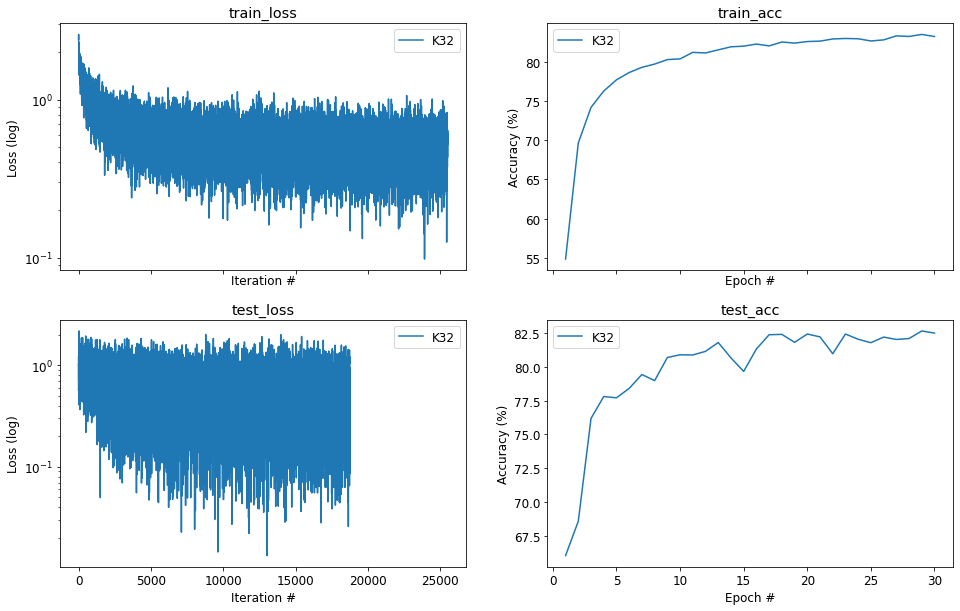

In [ ]:
plot_exp_results('exp1_2_K32.json') # plot your experiments results

### 2. Learning rate and optimization method
Tune the optimization algorithm (try SGD with momentum and Adam) and the learning rate (try values between 0.0005-1, try no more than five values).

In [ ]:
# set ycn=True when you call experiments.run_experiment(...). 
# Use meaningful names!
# ====== YOUR CODE: ======
for optim in ['sgd','adam']:
    for lr in [0.0005,0.1,0.01]:
        # Test experiment1 implementation on a few data samples and with a small model
        experiments.run_experiment(f'exp2_2_{optim}_lr{lr}',
                                   seed=seed,
                                   bs_train=64,
                                   batches=200,
                                   epochs=30, 
                                   early_stopping=5,
                                   reg=2e-3,
                                   lr=lr,
                                   filters_per_layer=[32,64,128],
                                   layers_per_block=2,
                                   pool_every=2, 
                                   ycn=True, 
                                   sgd=(optim=='sgd'),
                                   hidden_dims=[128])

# ========================

Files already downloaded and verified
Files already downloaded and verified
YourCodeNet(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): MaxPool2d(kernel_siz

common config:  {'run_name': 'exp2_2_sgd_lr0.1', 'out_dir': './results', 'seed': 42, 'bs_train': 64, 'bs_test': 16, 'batches': 200, 'epochs': 30, 'early_stopping': 5, 'checkpoints': None, 'lr': 0.1, 'reg': 0.002, 'pool_every': 2, 'hidden_dims': [128], 'ycn': True, 'sgd': True, 'kw': {}}


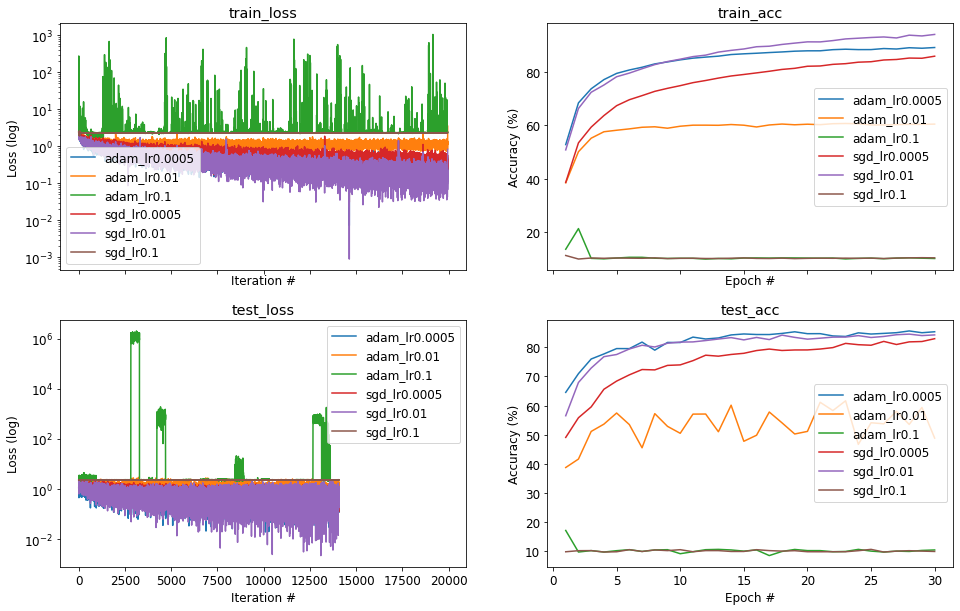

In [ ]:
plot_exp_results('exp2_2*') # plot your experiments results

**Answer in your Report:** Why should we add the momentum to SGD? What is the main two improvments adam has comparing to the simple SGD? What was the best optimization algorithm and best learning rate you've found?

Summarize this section results in your report.

**Note** - you will need to change the optimization used in experiments.run_experiment(...).

### 3. Add Batch Normalization
Add batch normalization to your network. You may want to read this blog before:
https://www.baeldung.com/cs/batch-normalization-cnn

In [ ]:
# set ycn=True when you call experiments.run_experiment(...)
# Use meaningful names!
# ====== YOUR CODE: ======
experiments.run_experiment(f'exp3_1_BN',
  seed=seed,
  bs_train=64,
  batches=200,
  epochs=30, 
  early_stopping=5,
  reg=2e-3,
  lr=1e-3,
  filters_per_layer=[32,64,128],
  layers_per_block=2,
  pool_every=2, 
  ycn=True, 
  hidden_dims=[128])
# ========================

Files already downloaded and verified
Files already downloaded and verified
YourCodeNet(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): MaxPool2d(kernel_siz

common config:  {'run_name': 'exp3_1_BN', 'out_dir': './results', 'seed': 42, 'bs_train': 64, 'bs_test': 16, 'batches': 200, 'epochs': 30, 'early_stopping': 5, 'checkpoints': None, 'lr': 0.001, 'reg': 0.002, 'pool_every': 2, 'hidden_dims': [128], 'ycn': True, 'sgd': False, 'kw': {}}


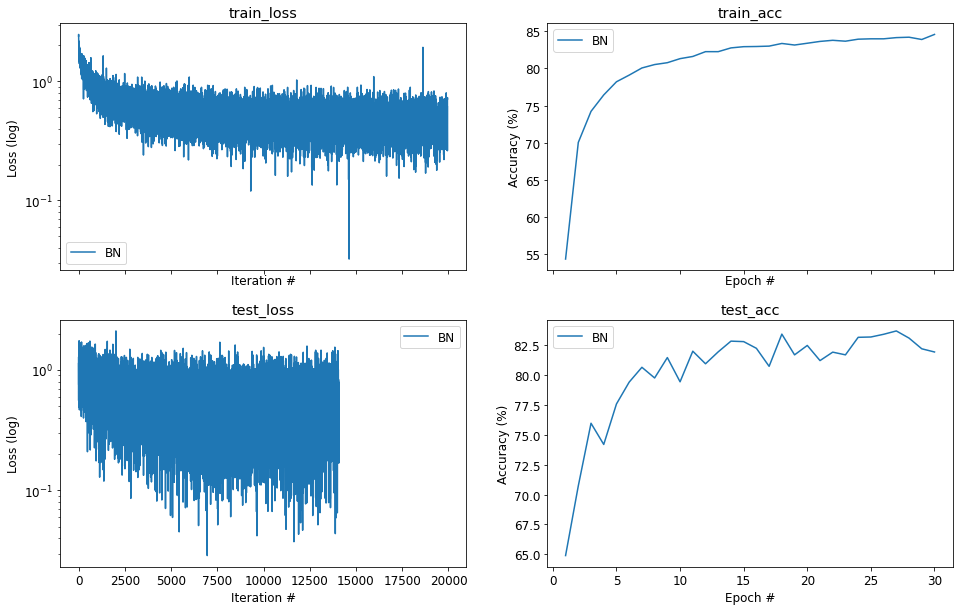

In [ ]:
plot_exp_results('exp3*') # plot your experiments results

**Answer in your Report:** What is the purpose of batch normalization (why do we use it)? 
Did the Batch normalization improve the network preformance?
Summeraize this section results in your report.

### 4. Regularization
Try to add regularization to your optimization. In particular add L2 regularization (read about weight_decay in adam) and dropout layer to your network (try them separately).

In [ ]:
# set ycn=True when you call experiments.run_experiment(...)
# Use meaningful names!
# ====== YOUR CODE: ======
for reg, dropouts in [(0, True), (2e-3, False)]:
  regType = 'Dropouts' if dropouts else 'L2'
  experiments.run_experiment(f'exp4_1_REG_{regType}',
    seed=seed,
    bs_train=64,
    batches=200,
    epochs=30, 
    early_stopping=5,
    reg=reg,
    dropouts=dropouts,
    lr=1e-3,
    filters_per_layer=[32,64,128],
    layers_per_block=2,
    pool_every=2, 
    ycn=True, 
    hidden_dims=[128])
# ========================

Files already downloaded and verified
Files already downloaded and verified
YourCodeNet(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ce

common config:  {'run_name': 'exp4_1_REG_L2', 'out_dir': './results', 'seed': 42, 'bs_train': 64, 'bs_test': 16, 'batches': 200, 'epochs': 30, 'early_stopping': 5, 'checkpoints': None, 'lr': 0.001, 'reg': 0.002, 'pool_every': 2, 'hidden_dims': [128], 'ycn': True, 'sgd': False, 'dropouts': False, 'kw': {}}


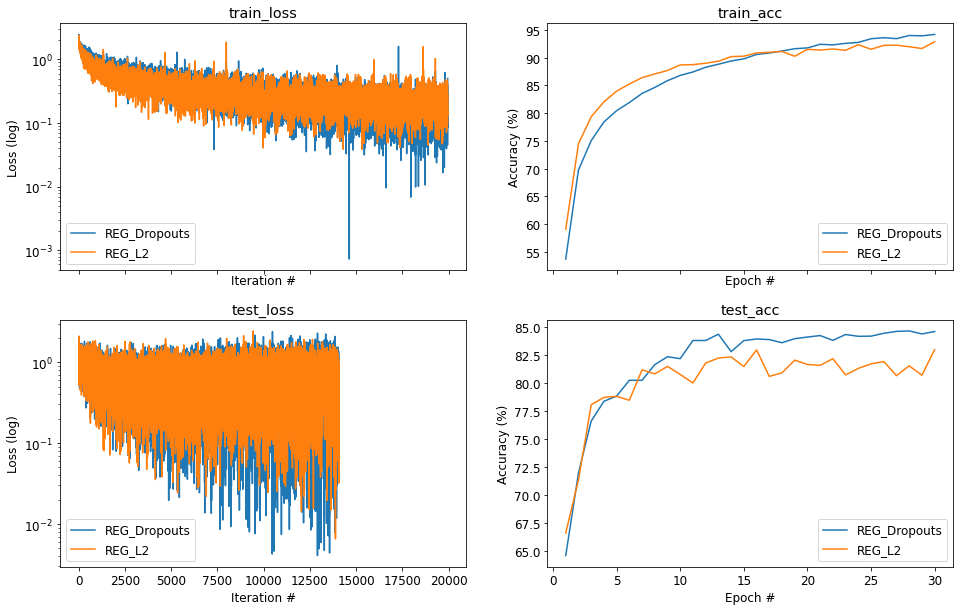

In [ ]:
plot_exp_results('exp4*') # plot your experiments results

**Answer in your Report:** Why should we use regularization?
How does the regularization affect the train accuracy and loss? How does it affect the val and test accuracy and loss? What was the best regulrization method? 
Summarize this section results in your report.

## Summary Up To Here
**Answer in your Report:** What is your best architecture? what its best accuracy and loss on the test set? Compare your result to assignment 2. How did you mange to improve the model? Summarize this section results in your report. 

## Use predefined network
You may want to read about ResNet in this blog:

https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035

### 5. Pretrained ResNet50

Now use ResNet50 with pretraining (use pretrained=True when you load the model) and run this model on cifar 10.
you will need to change the last linear layer. Tip: `model.fc = nn.Linear(2048, 10)`. you may want to use lower learning rate.

In [ ]:

# Use meaningful names!
# ====== YOUR CODE: ======
# net = models.resnet50(pretrained=True).to(device) 

# for param in net.parameters():
#     param.requires_grad = False
    
# net.fc = nn.Sequential(
#                nn.Linear(2048, 10)).to(device)

experiments.run_experiment(f'exp5_3_resnet_50',
    seed=seed,
    bs_train=64,
    batches=200,
    epochs=30,
    early_stopping=5,
    lr=1e-5,
    filters_per_layer=[32,64,128],
    layers_per_block=2,
    pool_every=2, 
    ycn=True, 
    resnet=True,
    hidden_dims=[128])

# ========================

Files already downloaded and verified
Files already downloaded and verified
Layer "layer4" was unfrozen!
Layer "layer4" was unfrozen!
Layer "layer4" was unfrozen!
optimizer : Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.001
)
--- EPOCH 1/30 ---
test_batch (Avg. Loss 0.935, Accuracy 67.0): 100%|██████████| 469/469 [01:05<00:00,  7.43it/s]
--- EPOCH 2/30 ---
test_batch (Avg. Loss 0.865, Accuracy 69.4): 100%|██████████| 469/469 [01:04<00:00,  7.61it/s]
--- EPOCH 3/30 ---
test_batch (Avg. Loss 0.893, Accuracy 70.2): 100%|██████████| 469/469 [01:07<00:00,  7.34it/s]
--- EPOCH 4/30 ---
test_batch (Avg. Loss 0.955, Accuracy 70.1): 100%|██████████| 469/469 [01:05<00:00,  7.19it/s]
--- EPOCH 5/30 ---
test_batch (Avg. Loss 1.016, Accuracy 70.5): 100%|██████████| 469/469 [01:06<00:00,  7.38it/s]
--- EPOCH 6/30 ---
test_batch (Avg. Loss 1.038, Accuracy 70.3): 100%|██

common config:  {'run_name': 'exp5_2_resnet_50', 'out_dir': './results', 'seed': 42, 'bs_train': 64, 'bs_test': 16, 'batches': 200, 'epochs': 30, 'early_stopping': 5, 'checkpoints': None, 'lr': 1e-05, 'reg': 0.001, 'pool_every': 2, 'hidden_dims': [128], 'ycn': True, 'sgd': False, 'dropouts': True, 'resnet': True, 'kw': {}}


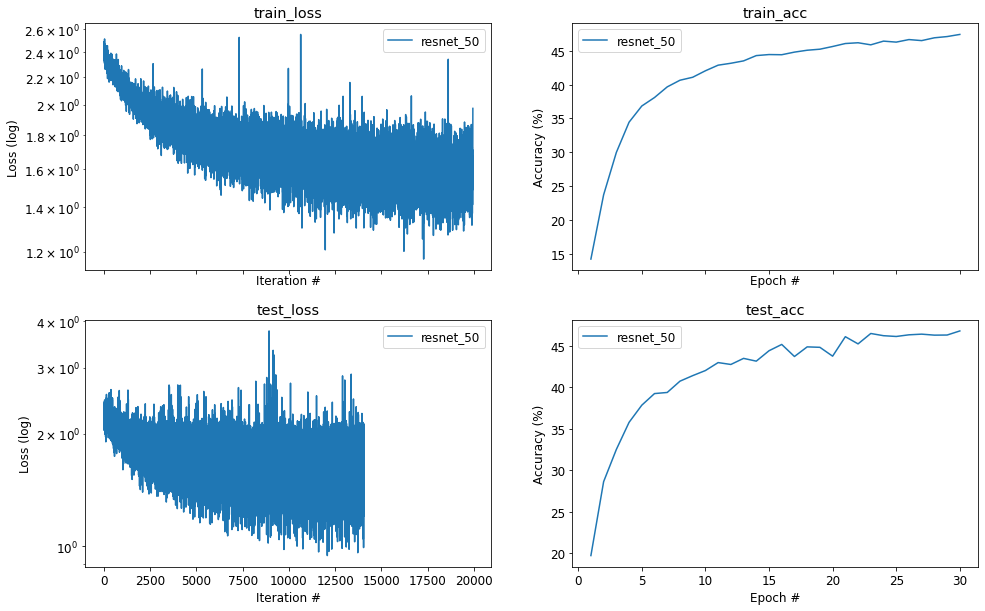

In [ ]:
plot_exp_results('exp5_2*') # plot your experiments results

**Answer in your Report:** What was the pretrained ResNet50 accuracy and loss? Is it overfit/underfit/well-fit the data? Has it got better accuracy than the non-pretrained ResNet? Summarize this section results in your report.

### 5. Summeraize Bert and ViT blogs
Read these two blogs:
1. https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270
2. https://towardsdatascience.com/what-are-vision-transformers-and-how-are-they-important-for-general-purpose-learning-edd008545e9e

Summeraize the bert and ViT information from these two blogs in hebrew.


## Project Summary
**Answer in your Report:** Write a short summerization of your attempts. What worked for you? which architecture and hyperparameters led to the best preformance?